# Distributed Model Representations in Dmipy

The typical diameter of a white matter axon ranges between [0.1 - 2$\mu m$] *(Aboitiz et al. 1992)*, while the dMRI imaging resolution is typically around [1-2] $mm^3$. This means that for every voxel we are not measuring the signal of a single axon, but the average signal for large ensembles of axons and other neurites whose properties can vary within that same voxel. To estimate meaningful tissue microstructure parameters from the dMRI signal many approaches to represent these parameter *distributions* have been proposed. In Microstructure Imaging, the most intensely studied parameter distributions have been the *axon orientation dispersion distribution* and the *axon diameter distribution*.

The axon orientation dispersion distribution refers to the phenomenon that axons are not all pointed in exactly the same directions within one axon bundle. Instead, their orientations are spread around the main bundle axis with some distribution. In Microstructure Imaging, these distributions are often model as Watson, Bingham or Spherical Harmonics distributions.

The axon diameter distribution refers to the fact that the axon diameter varies within the same axon bundle. This distribution is often modelled as a Gamma distribution.

Dmipy allows you to create orientation-dispersed, diameter-distributed (or both at the same time) representations for e.g. axon bundles. 

## Creating an axon-dispersed bundle representation

In Microstructure Imaging, the brain's axon bundles are typically represented as having both an intra- and an extra-axonal compartment. Intra-axonal compartments are typically represented using cylinder models, while extra-axonal compartments are typically Gaussian. To simulate the phenomenon of axon dispersion, it is possible to see a dispersed bundle as an ensemble of a single parallel "micro-environments", which exist with some probability for different orientations.

Dmipy allows to create such a "bundle representation" using distribute_models module. A distributed model can be seen as a type of sub-multi-compartment model that can contain multiple single models representations (e.g. Sticks, Cylinders, Zeppelin) - **as long as they have an orientation**. The contained single models all experience the same distribution parameters. Currently, is possible to choose between the parametric Watson or Bingham distributions.

### Watson-Dispersed Zeppelin and Stick representation
We will start by creating a Watson-dispersed Stick and Zeppelin representation.

In [1]:
from dmipy.signal_models import gaussian_models, cylinder_models
from dmipy.distributions import distribute_models

stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
watson_bundle = distribute_models.SD1WatsonDistributed(models=[stick, zeppelin])

We can list the parameters of this representation as follows:

In [2]:
watson_bundle.parameter_names

['G2Zeppelin_1_lambda_perp',
 'SD1Watson_1_odi',
 'G2Zeppelin_1_lambda_par',
 'SD1Watson_1_mu',
 'C1Stick_1_lambda_par',
 'partial_volume_0']

The parameters 'SD1Watson_1_odi' and 'SD1Watson_1_mu' represent the Orientation Dispersion Index (ODI) and orientation of the Watson distribution. The others are parameters of the Stick and Zeppelin models.

Notice is that there is only one "mu" parameter, as the orientation of the Stick and Zeppelin are now tied to that of the Watson distribution, i.e. the Stick and Zeppelin are now always aligned.

Lastly, the 'partial_volume_0' parameter represents the volume fraction of the first input model - in our case the stick - where the second volume fraction is defined as partial_volume_1 = 1-partial_volume_0.

### Bingham-dispersed Zeppelin and Stick representation
A Bingham-dispersed representation is made in the same way:

In [3]:
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
bingham_bundle = distribute_models.SD2BinghamDistributed(models=[stick, zeppelin])
bingham_bundle.parameter_names

['SD2Bingham_1_odi',
 'SD2Bingham_1_beta_fraction',
 'G2Zeppelin_1_lambda_perp',
 'SD2Bingham_1_psi',
 'SD2Bingham_1_mu',
 'G2Zeppelin_1_lambda_par',
 'C1Stick_1_lambda_par',
 'partial_volume_0']

Now the additional parameters 'psi' and 'beta_fraction' have been introduced, which can represent dispersion anisotropy.

## Creating an axon diameter distributed bundle representation

In the same way, it is also possible to create an axon diameter distributed bundle representation. For this example, we model an diameter-distributed Gaussian-Phase cylinder:

In [4]:
cylinder = cylinder_models.C4CylinderGaussianPhaseApproximation()
gamma_bundle = distribute_models.DD1GammaDistributed(models=[cylinder])
gamma_bundle.parameter_names

['C4CylinderGaussianPhaseApproximation_1_mu',
 'C4CylinderGaussianPhaseApproximation_1_lambda_par',
 'DD1Gamma_1_beta',
 'DD1Gamma_1_alpha']

Notice that the distributed model has no 'diameter' parameter, but instead has the shape 'alpha' and scale 'beta' parameters of the Gamma distribution.

## Creating an orientation dispersed AND diameter distributed bundle representation

Dmipy is constructed in such a modular way that Watson/Bingham-dispersed bundle representation can be used as input for Gamma-distributed models, and the other way around. (It is noteworthy that dispersing a distributed model and distributing a dispersed model is mathematically the same).

For this example, let us make a close-to-complete white matter representation (for single bundles) that can be made in PGSE-dMRI, combining Bingam-dispersed axon orientations *(Sotiropoulos et al. 2012)*, distributed axon diameters *(Assaf et al. 2008)*, and restricted extra-axonal diffusion *(Burcaw et al. 2015)*:

In [5]:
# import the base model components
cylinder = cylinder_models.C4CylinderGaussianPhaseApproximation()
restricted_zeppelin = gaussian_models.G3TemporalZeppelin()

bingham_bundle = distribute_models.SD2BinghamDistributed(models=[cylinder, restricted_zeppelin])
bingham_bundle.parameter_names

['SD2Bingham_1_odi',
 'SD2Bingham_1_beta_fraction',
 'SD2Bingham_1_psi',
 'G3TemporalZeppelin_1_lambda_inf',
 'SD2Bingham_1_mu',
 'C4CylinderGaussianPhaseApproximation_1_lambda_par',
 'C4CylinderGaussianPhaseApproximation_1_diameter',
 'G3TemporalZeppelin_1_A',
 'G3TemporalZeppelin_1_lambda_par',
 'partial_volume_0']

To also distribute the diameter of the cylinder model, we must now set the 'target_parameter' variable to the correct name in the dispersed model:

In [6]:
gamma_bingham_bundle = distribute_models.DD1GammaDistributed(
    models=[bingham_bundle],
    target_parameter='C4CylinderGaussianPhaseApproximation_1_diameter')

Creating the multi-compartment model that can (technically) be fitted is then as in the previous examples.

In [7]:
from dmipy.core.modeling_framework import MultiCompartmentModel
white_matter_mc_model = MultiCompartmentModel(models=[gamma_bingham_bundle])
white_matter_mc_model.parameter_names

['DD1GammaDistributed_1_SD2BinghamDistributed_1_C4CylinderGaussianPhaseApproximation_1_lambda_par',
 'DD1GammaDistributed_1_DD1Gamma_1_beta',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_SD2Bingham_1_odi',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_partial_volume_0',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_SD2Bingham_1_psi',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_SD2Bingham_1_mu',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_G3TemporalZeppelin_1_lambda_par',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_G3TemporalZeppelin_1_A',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_SD2Bingham_1_beta_fraction',
 'DD1GammaDistributed_1_DD1Gamma_1_alpha',
 'DD1GammaDistributed_1_SD2BinghamDistributed_1_G3TemporalZeppelin_1_lambda_inf']

We can even visualize the flow of models (and their raw parameters) as a graph.

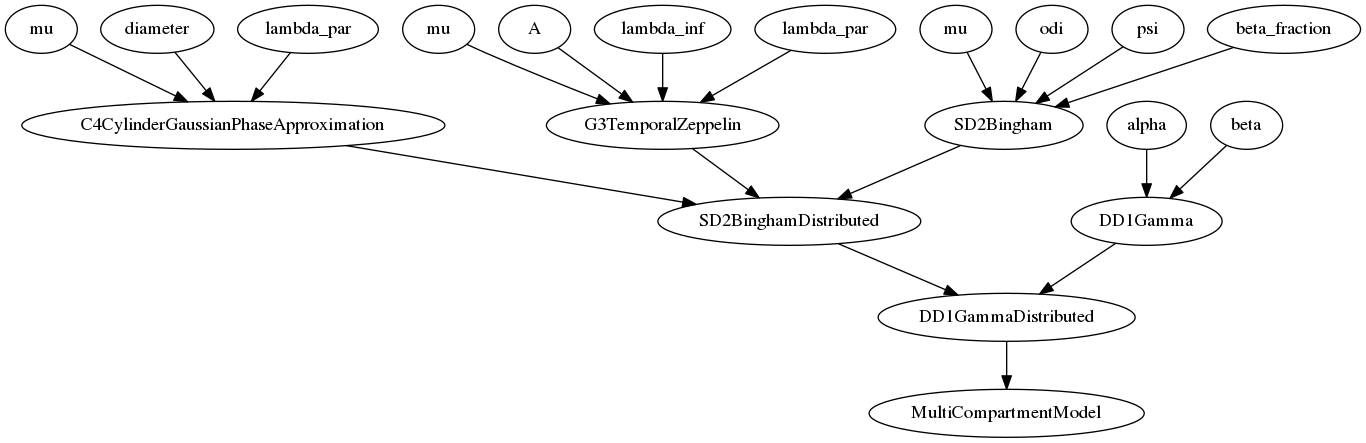

In [8]:
from IPython.display import Image
white_matter_mc_model.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

It can be seen that including all these tissue properties means that the model will have many parameters. Nonetheless, this model is fittable to any data set as all previous ones.

However, It is important to realize the the more complicated the model (the more parameters), the more local minima there are, the more parameter combinations will produce the same fitting error, and the longer the optimization time. In fact, *(Jelescu et al. 2016)* already showed that estimating the diffusivity and dispersion in the NODDI model at the same time results in multiple parameter solutions with the same fitting error. 

To have meaningful results, it is therefore always important to make sure the model you are fitting is not more complex than the data you have!

## References
- Aboitiz, Francisco, et al. "Fiber composition of the human corpus callosum." Brain research 598.1 (1992): 143-153.
- Sotiropoulos, Stamatios N., Timothy EJ Behrens, and Saad Jbabdi. "Ball and rackets: inferring fiber fanning from diffusion-weighted MRI." Neuroimage 60.2 (2012): 1412-1425.
- Assaf, Yaniv, et al. "AxCaliber: a method for measuring axon diameter distribution from diffusion MRI." Magnetic resonance in medicine 59.6 (2008): 1347-1354. 
- Burcaw, Lauren M., Els Fieremans, and Dmitry S. Novikov. "Mesoscopic structure of neuronal tracts from time-dependent diffusion." NeuroImage 114 (2015): 18-37.
- Jelescu, Ileana O., et al. "Degeneracy in model parameter estimation for multi‐compartmental diffusion in neuronal tissue." NMR in Biomedicine 29.1 (2016): 33-47.